In [1]:

#Sebastian Russo
#Artificial Intelligence

#Import necessary libraries
#Library to manipulate and analyze datasets 
import pandas as pd 
import numpy as np

#------------------------------------------------------------------------------------------------
#Import the KMeans clustering and other important related libraries
from sklearn.cluster import KMeans
#For reducing dimensions to 2D for plotting
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from kneed import KneeLocator #For finding the best possible cluster

#Module contains various functions for evaluating the performance of the KMeans cluster
from sklearn.metrics import silhouette_score, silhouette_samples, calinski_harabasz_score, davies_bouldin_score
#------------------------------------------------------------------------------------------------
#Library to make python matplotlib work like MATLAB
import matplotlib.pyplot as plt  
import matplotlib.cm as cm

#Library for data visualization
import seaborn as sns 

#To import the class in for feature scaling (standardize the range of independent variables)
from sklearn.preprocessing import StandardScaler #COMPLETELY OPTIONAL WE DECIDED TO USE

#To save the trained model
import os
import joblib

In [2]:
#Import data set
df_e_commerce_dataset = pd.read_csv("ecommerce_data.csv", encoding='ISO-8859-1')

#View shape of dataset (number of rows and columns)
print("Rows and Columns:", end="")
print(df_e_commerce_dataset.shape)

#Check most and least common countries
print("Most common country:", df_e_commerce_dataset['Country'].mode()[0])
print("Least common country:", df_e_commerce_dataset['Country'].value_counts().idxmin())

#Analyze dataset by looking at first 5 rows
df_e_commerce_dataset.head(5)

Rows and Columns:(541909, 8)
Most common country: United Kingdom
Least common country: Saudi Arabia


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [3]:
#Check if there is any missing values in the data (should always be done in large datasets)
num_missing_values=df_e_commerce_dataset.isna().sum() #or .isnull().sum()

#Print to see the missing values
print(num_missing_values)

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [4]:
#Clean data by replacing missing values, drop unnecessary columns or columns with too many missing 
df_e_commerce_dataset = df_e_commerce_dataset.dropna(subset=['CustomerID','Description'])

#Convert InvoiceDate to date time
df_e_commerce_dataset['InvoiceDate'] = pd.to_datetime(df_e_commerce_dataset['InvoiceDate'])

#Create total price column
df_e_commerce_dataset['TotalPrice'] = df_e_commerce_dataset['Quantity'] * df_e_commerce_dataset['UnitPrice']

#Aggregate data in this case to a customer level
customer_df = df_e_commerce_dataset.groupby('CustomerID').agg({
    'InvoiceNo': 'nunique',          #Number of distinct invoices (purchases)
    'Quantity': 'sum',               #Total items bought
    'TotalPrice': 'sum',             #Total money spent
    'Country': 'first'               #Keep for reference
}).rename(columns={
    'InvoiceNo': 'NumPurchases',
    'Quantity': 'TotalQuantity',
    'TotalPrice': 'TotalSpent'
}).reset_index()

#Handle outliers and skewed data
#Remove extreme outliers based on quantiles
customer_df = customer_df[
    (customer_df['TotalSpent'] < customer_df['TotalSpent'].quantile(0.99)) &
    (customer_df['TotalQuantity'] < customer_df['TotalQuantity'].quantile(0.99))
]
customer_df = customer_df[
    (customer_df['TotalSpent'] >= 0) &
    (customer_df['TotalQuantity'] >= 0) &
    customer_df['TotalSpent'].notna() &
    customer_df['TotalQuantity'].notna()
]

#Apply log transform to reduce skewness
customer_df['LogTotalSpent'] = np.log1p(customer_df['TotalSpent'])
customer_df['LogTotalQuantity'] = np.log1p(customer_df['TotalQuantity'])
print(customer_df[['LogTotalSpent', 'LogTotalQuantity']].head())


   LogTotalSpent  LogTotalQuantity
0       0.000000          0.000000
1       8.368925          7.807510
2       7.494564          7.758761
3       7.472245          6.448889
4       5.815324          5.288267


In [5]:
#Feature scale with Standard scaler
features = customer_df[['NumPurchases', 'LogTotalQuantity', 'LogTotalSpent']]

#Replace inf with NaN and rows with NaN
features = features.copy()
features.replace([np.inf, -np.inf], np.nan, inplace=True)
features = features.dropna()

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

Optimal number of clusters according to Elbow Method: 3


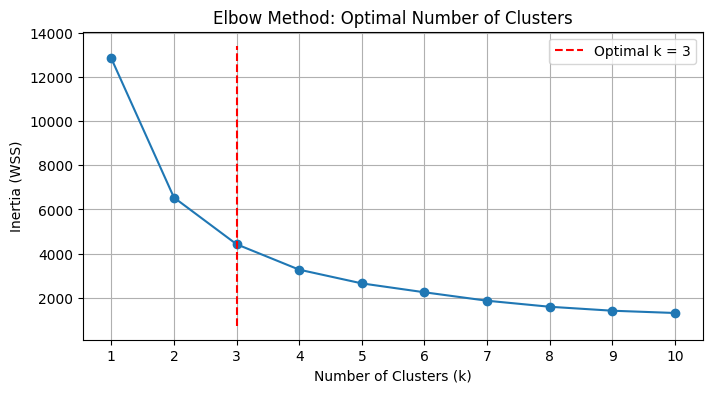

In [6]:
#Determine optimal number of clusters using Elbow Method
inertias = []
k_range = range(1, 11)
for k in k_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(scaled_features)
    inertias.append(km.inertia_)

#Find the elbow/knee point
knee = KneeLocator(k_range, inertias, curve='convex', direction='decreasing')
optimal_k = knee.knee #NOTE: 2 clusters yield simpler, slightly clearer separation
print(f"Optimal number of clusters according to Elbow Method: {optimal_k}")

#Plot
plt.figure(figsize=(8, 4))
plt.plot(k_range, inertias, marker='o')
plt.vlines(optimal_k, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', colors='red', label=f'Optimal k = {optimal_k}')
plt.title("Elbow Method: Optimal Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (WSS)")
plt.xticks(k_range)
plt.grid(True)
plt.legend()
plt.show()


In [7]:
#Create the model
k_means_cluster = KMeans(n_clusters=optimal_k, random_state=42) #use the most optimal number of clusters

#Train the model (fit on the scaled features)
k_means_cluster.fit(scaled_features)

#Assign clusters to the original customer DataFrame
customer_df['Cluster'] = k_means_cluster.labels_

#Cluster profiling: understand each customer group
cluster_profiles = customer_df.groupby('Cluster').agg({
    'NumPurchases': 'mean',
    'TotalQuantity': 'mean',
    'TotalSpent': 'mean',
    'CustomerID': 'count'
}).rename(columns={'CustomerID': 'NumCustomers'})
print("\nCluster Profiling Summary:")
print(cluster_profiles)

#Save the trained model and scaler
os.makedirs('trained_model', exist_ok=True)
joblib.dump(k_means_cluster, 'trained_model/k_means_cluster_customer_segmentation.pkl')
joblib.dump(scaler, 'trained_model/kmeans_scaler.pkl')


Cluster Profiling Summary:
         NumPurchases  TotalQuantity   TotalSpent  NumCustomers
Cluster                                                        
0            1.653213     151.894849   280.643432          1883
1            4.549522     913.337355  1477.254611          1989
2           18.274074    3180.844444  5615.459407           405


['trained_model/kmeans_scaler.pkl']

In [8]:
#Create a new sample customer data point
new_customer_data = pd.DataFrame([[5, 30, 500]], columns=['NumPurchases', 'TotalQuantity', 'TotalSpent'])

#Apply the same log transformations as for training data
new_customer_data['LogTotalQuantity'] = np.log1p(new_customer_data['TotalQuantity'])
new_customer_data['LogTotalSpent'] = np.log1p(new_customer_data['TotalSpent'])

#Select only the features scaler was fitted on
new_features = new_customer_data[['NumPurchases', 'LogTotalQuantity', 'LogTotalSpent']]

#Now transform with scaler
new_scaled_features = scaler.transform(new_features)

#Predict the cluster
predicted_clusters = k_means_cluster.predict(new_scaled_features)
print(predicted_clusters)
print("Top 10 Customer Clusters:\n", customer_df[['CustomerID', 'Cluster']].head(10))


[0]
Top 10 Customer Clusters:
    CustomerID  Cluster
0     12346.0        0
1     12347.0        1
2     12348.0        1
3     12349.0        1
4     12350.0        0
5     12352.0        1
6     12353.0        0
7     12354.0        1
8     12355.0        0
9     12356.0        1


In [9]:
#Evaluation Metrics
inertia = k_means_cluster.inertia_
sil_score = silhouette_score(scaled_features, k_means_cluster.labels_)
calinski_harabasz = calinski_harabasz_score(scaled_features, k_means_cluster.labels_)
davies_bouldin = davies_bouldin_score(scaled_features, k_means_cluster.labels_)

print(f"Number of clusters {optimal_k}")
print(f"Inertia (Within-Cluster Sum of Squares): {inertia:.2f}")
print(f"Silhouette Score: {sil_score:.3f}")
print(f"Calinski-Harabasz Index: {calinski_harabasz:.2f}")
print(f"Davies-Bouldin Index: {davies_bouldin:.3f}")

Number of clusters 3
Inertia (Within-Cluster Sum of Squares): 4426.61
Silhouette Score: 0.450
Calinski-Harabasz Index: 4057.37
Davies-Bouldin Index: 0.741


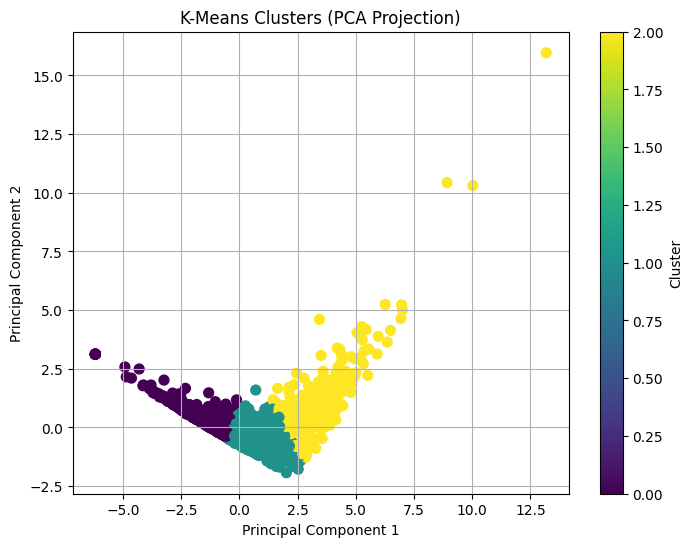

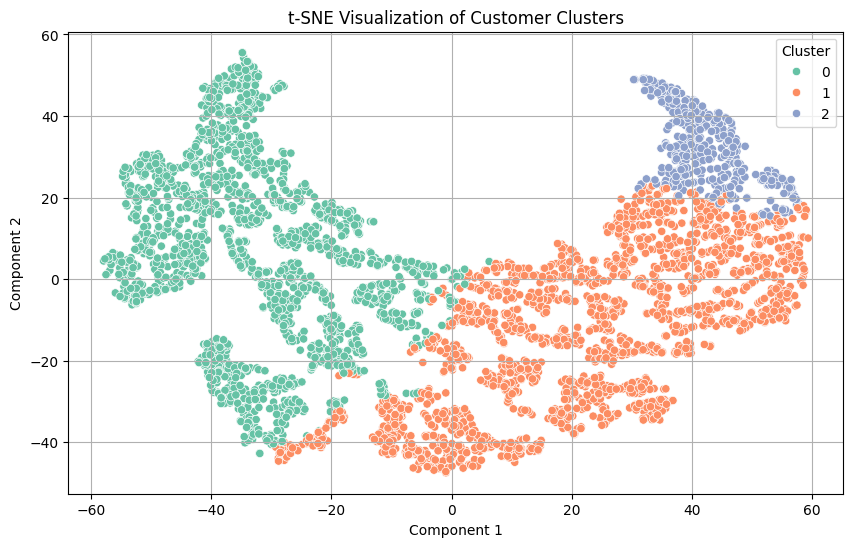

In [10]:
#Data visualization
#PCA Visualization (2D)
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_features)

plt.figure(figsize=(8, 6))
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=k_means_cluster.labels_, cmap='viridis', s=50)
plt.title("K-Means Clusters (PCA Projection)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

#t-SNE Visualization (2D)
tsne_results = TSNE(n_components=2, perplexity=50, random_state=42).fit_transform(scaled_features)

#Plotting the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=customer_df['Cluster'], palette='Set2')
plt.title("t-SNE Visualization of Customer Clusters")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.show()

Silhouette Score for k=3: 0.450


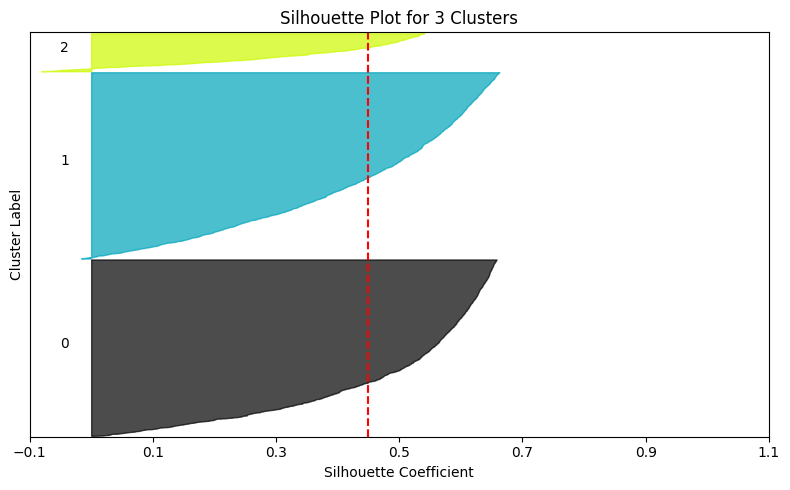

In [11]:
#Use the number of clusters found by KneeLocator
fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(8, 5)

ax1.set_xlim([-0.1, 1])
ax1.set_ylim([0, len(scaled_features) + (optimal_k + 1) * 10])

#Initialize and fit the KMeans clusterer
clusterer = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = clusterer.fit_predict(scaled_features)

#Compute average silhouette score
silhouette_avg = silhouette_score(scaled_features, cluster_labels)
print(f"Silhouette Score for k={optimal_k}: {silhouette_avg:.3f}")

#Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(scaled_features, cluster_labels)

y_lower = 10
for i in range(optimal_k):
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / optimal_k)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)

    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

ax1.set_title(f"Silhouette Plot for {optimal_k} Clusters")
ax1.set_xlabel("Silhouette Coefficient")
ax1.set_ylabel("Cluster Label")
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
ax1.set_yticks([])
ax1.set_xticks(np.arange(-0.1, 1.1, 0.2))

plt.tight_layout()
plt.show()
